In [41]:
using Random, Distributions
using Plots, StatsBase
gr()
Random.seed!(2748917)

MersenneTwister(UInt32[0x0029f1f5], Random.DSFMT.DSFMT_state(Int32[1199225368, 1073309067, 1960348149, 1073260391, -1527229543, 1072794150, 726898173, 1073389620, 858226550, 1073032999  …  664203925, 1072920611, -911988340, 1073686208, 578978275, -1246878297, -868136413, 470845598, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

In [2]:
k = 10

levers = Vector{Normal}()

for i in 1:k
    append!(levers, [Normal(rand(Uniform(-3.0, 5.0)), rand(Uniform(1.0, 2.0)))])
end

levers

10-element Array{Normal,1}:
 Normal{Float64}(μ=-2.1955882233414616, σ=1.8416524064297695)
 Normal{Float64}(μ=-0.8530481468114246, σ=1.4099445561033053)
 Normal{Float64}(μ=-2.4864351793530997, σ=1.8410524241915769)
 Normal{Float64}(μ=1.2886020576460133, σ=1.3973356714263332)
 Normal{Float64}(μ=-2.3534325283496074, σ=1.5263496284429063)
 Normal{Float64}(μ=3.519577255479465, σ=1.3742167656057425)
 Normal{Float64}(μ=-2.5574593219999926, σ=1.0324237702397163)
 Normal{Float64}(μ=0.043396223103767895, σ=1.949598437008904)
 Normal{Float64}(μ=1.7870060267375099, σ=1.0645038083468665)
 Normal{Float64}(μ=-1.8465624491038426, σ=1.0535199101856734)

In [30]:
bandit(lever) = rand(levers[lever])

function epsilon_greedy(num_iter, epsilon, alpha, optimistic)
    value = 0
    value_table = [0.0]
    Q = [optimistic ? 8.0 : 0.0 for x in 1:k] 
    action = 0
    
    for i in 1:num_iter
        explore = rand(Uniform(0.0, 1.0))
        if explore > epsilon
            action = findmax(Q)[2]
        else
            action = rand(1:k)
        end

        reward = bandit(action)
        value += reward
        push!(value_table, value / i)
        Q[action] += alpha * (reward - Q[action])
    end
    
    value_table
end


epsilon_greedy (generic function with 2 methods)

In [26]:
function UCB(num_iter, c, alpha)
    value = 0
    value_table = [0.0]
    Q = [0.0 for x in 1:k]
    
    N = [0 for x in 1:k]
    action = 0
    for i in 1:num_iter
        confidence = [c*sqrt(log(i)/N[x]) for x in 1:k]
        
        action = findmax(Q + confidence)[2]
        reward = bandit(action)
        value += reward
        push!(value_table, value / i)
        Q[action] += alpha * (reward - Q[action])
        N[action] += 1
    end
    
    value_table
end

UCB (generic function with 1 method)

In [96]:
function stochastic_gradient(num_iter, alpha)
    value = 0
    value_table = [0.0]
    H = [0.0 for x in 1:k]
    ex(n) = 2.718^n
    action = 1
    for i in 1:num_iter
        Hsum = sum(ex.(H))
        pi = [ex(H[x])/Hsum for x in 1:k]
        action = sample(1:k, Weights(pi))

        reward = bandit(action)
        value += reward
        push!(value_table, value / i)
        
        #=
            Something here seems wrong... H is not being updated properly
        =#
        for x in 1:k
            if action == x
                H[action] += alpha * (reward - (value/i)) * (1 - pi[x])
            else
                H[action] -= alpha * (reward - (value/i)) * pi[x]
            end
        end
        
    end
    value_table
    
end

stochastic_gradient (generic function with 1 method)

In [98]:
stochastic_gradient(100, 200)

101-element Array{Float64,1}:
  0.0
  2.918298744164347
  1.8472650942020978
  1.5677113832273364
  1.2599339945662993
  0.19224003213287588
 -0.055933386879044956
 -0.13020461697500335
 -0.21147429478210392
 -0.1755176494021721
 -0.28652100310494
  0.0966004391739963
 -0.10863266652290393
  ⋮
 -0.6017509705757403
 -0.621922284189015
 -0.6326113499627375
 -0.6779894723452965
 -0.708262778260985
 -0.6875268348444663
 -0.7081296310070248
 -0.6806585543040077
 -0.709884267214049
 -0.6751929338512384
 -0.6984562611591499
 -0.6558882193334407

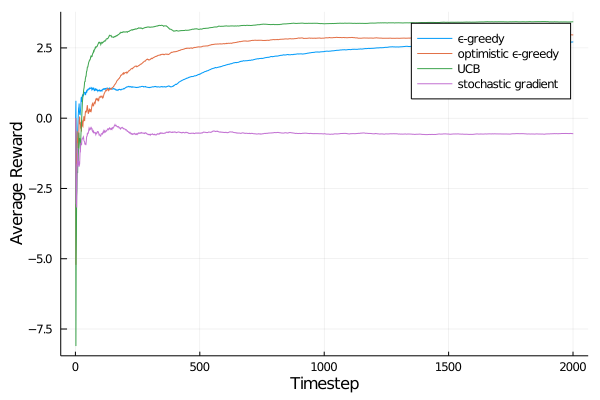

In [102]:
value_table = epsilon_greedy(2000, 0.1, 1/k, false)
plot(1:size(value_table)[1], value_table, label="ϵ-greedy")
xaxis!("Timestep")
yaxis!("Average Reward")

value_table = epsilon_greedy(2000, 0.1, 1/k, true)
plot!(1:size(value_table)[1], value_table, label="optimistic ϵ-greedy")

value_table = UCB(2000, 2, 1/k)
plot!(1:size(value_table)[1], value_table, label="UCB")

value_table = stochastic_gradient(2000, 0.1)
plot!(1:size(value_table)[1], value_table, label="stochastic gradient")